# Классификация P. multifida и P. turczaninovii

Этапы:
1. Переименовать фотографии.
2. Сделать датасет.
3. Fine tune some NNs.

## Installation

## Импорт библиотек

In [1]:
import os
import re
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms.v2 as v2
import torchvision.transforms as T
import PIL
import numpy as np
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from tqdm import tqdm
import pandas as pd
from PIL import Image
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
from torchvision import models
import cv2

In [3]:
import random

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

## Важные переменные

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
class1_folder = '/content/drive/MyDrive/plants_classification/P. multifida'
class2_folder = '/content/drive/MyDrive/plants_classification/P. turczaninovii'
hybrid_class_folder = '/content/drive/MyDrive/plants_classification/Hybrid'
project_folder = '/content/drive/MyDrive/plants_classification'

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

in_channel = 3
num_classes = 2
learning_rate = 3e-4
batch_size = 20
num_epochs = 500

In [13]:
def balance_dataset(new_df: pd.DataFrame, colname: str) -> pd.DataFrame:
    col_vals  = sorted(dict(new_df[colname].value_counts()).items(),
                   key=lambda x: x[-1], reverse=True)

    print(col_vals)

    max_col_val = col_vals.pop(0)

    for col_val in col_vals:

        if (max_col_val[1] > col_val[1]):
            nrecords = max_col_val[1] - col_val[1]
            d, m = divmod(nrecords, col_val[1])
            while d:
                tmp = new_df.loc[new_df[colname] == col_val[0]].sample(n = col_val[1])
                new_df = pd.concat([new_df, tmp], ignore_index=True)
                d -= 1
            if m:
                tmp = new_df.loc[new_df[colname] == col_val[0]].sample(n = nrecords % col_val[1])
                new_df = pd.concat([new_df, tmp], ignore_index=True)
        else:
            continue

    return new_df

In [ ]:
# SUPPORTED_IMAGE_FORMATS = ("jpg", "png", "tif", "jpeg", "svg")

## Работа с данными

### Переименование файлов

In [ ]:
# def rename_files(directory, pattern):
#     files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
#     files.sort()

#     for i, filename in enumerate(files):
#         base, ext = os.path.splitext(filename)
#         if re.search(r'\.(jpg|jpeg|png|gif|bmp)$', ext, re.IGNORECASE):
#             new_filename = pattern.format(i+1) + ext
#             old_path = os.path.join(directory, filename)
#             new_path = os.path.join(directory, new_filename)
#             os.rename(old_path, new_path)
#             img = Image.open(new_path)
#             img = img.resize((512, 512))
#             img.save(new_path)
#             print(f"Переименован файл: {filename} -> {new_filename}")

In [ ]:
# for folder in (class1_folder, class2_folder):
#   rename_files(os.path.join(folder, 'test'), "image_{:03d}")
#   rename_files(os.path.join(folder, 'train'), "image_{:03d}")

In [ ]:
# rename_files(hybrid_class_folder, "image_{:03d}")

### Создание аннотаций

In [7]:
annot_dict = {'name': [],
              'target': [],
              'mode': []}

for mode in ("train", "test"):
  for folder, label in ((class1_folder, 'P. multifida'),
                        (class2_folder, 'P. turczaninovii'),
                        (hybrid_class_folder, 'Hybrid')):
    for f in os.listdir(os.path.join(folder, mode)):
      annot_dict['name'] += [os.path.join(folder, mode, f)]
      annot_dict['target'] += [label]
      annot_dict['mode'] += [mode]

In [ ]:
# list(map(len, [annot_dict[key] for key in annot_dict.keys()]))

In [8]:
annot_df = pd.DataFrame(annot_dict)

In [10]:
annot_df.target.value_counts()

,count
target,
P. multifida,52
P. turczaninovii,52
Hybrid,10


In [17]:
os.makedirs('/content/drive/MyDrive/plants_classification/annotations', exist_ok=True)

In [18]:
annot_df = pd.DataFrame(annot_dict)
annot_df.to_csv(os.path.join('/content/drive/MyDrive/plants_classification/annotations', 'annotations_3_classes.csv'))

### Преобразование меток

In [27]:
annot_df = pd.read_csv('/content/drive/MyDrive/plants_classification/annotations/annotations_3_classes.csv')

annot_df = annot_df.drop(columns=['mode'])

df_multifida = annot_df.copy()
df_turczaninovii = annot_df.copy()
df_hybrid = annot_df.copy()

In [28]:
df_multifida['target'] = df_multifida['target'].map({'P. multifida': 1, 'P. turczaninovii': 0, 'Hybrid': 0})
df_turczaninovii['target'] = df_turczaninovii['target'].map({'P. multifida': 0, 'P. turczaninovii': 1, 'Hybrid': 0})
df_hybrid['target'] = df_hybrid['target'].map({'P. multifida': 0, 'P. turczaninovii': 0, 'Hybrid': 1})

In [29]:
df_multifida = balance_dataset(df_multifida, 'target')
df_turczaninovii = balance_dataset(df_turczaninovii, 'target')
df_hybrid = balance_dataset(df_hybrid, 'target')

[(0, np.int64(62)), (1, np.int64(52))]
[(0, np.int64(62)), (1, np.int64(52))]
[(0, np.int64(104)), (1, np.int64(10))]


### Создание датасета

In [32]:
train_img_preprocessing = v2.Compose([
        T.RandomHorizontalFlip(),
        T.RandomVerticalFlip(),
        T.RandomRotation(40),
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

base_img_preprocessing = v2.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [33]:
class PlantsDataset(Dataset):
  def __init__(self,
               annot_df: pd.DataFrame,
               preprocessing: v2.Compose = base_img_preprocessing):

    self.X_ids = annot_df.name.values
    self.y_vals = annot_df.target.values
    self.img_preprocessing = preprocessing

  def __len__(self):
    return self.X_ids.__len__()

  def __getitem__(self, index: int):
    X = Image.open(self.X_ids[index]).convert('RGB')
    X = self.img_preprocessing(X)
    y = torch.tensor(int(self.y_vals[index]))
    return (X, y)

In [ ]:
# Load Data
dataset = PlantsDataset(
    annot_df,
    preprocessing = train_img_preprocessing
)

train_records = annot_df
train_indexes = train_records.index.values
train_targets = train_records.target.values
train_indices, val_indices, _, _ = train_test_split(train_indexes, train_targets,
                                                    train_size=0.8,
                                                    stratify=train_targets)

train_set, val_set = Subset(dataset, train_indices), Subset(dataset, val_indices)

train_loader = DataLoader(dataset=train_set, batch_size=batch_size,
                          drop_last=True)
val_loader = DataLoader(dataset=val_set, batch_size=batch_size,
                        drop_last=True)

In [ ]:
model = torchvision.models.resnet50(weights="DEFAULT")

for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = False

model.fc = nn.Linear(in_features=2048, out_features=3, bias=True)
model.to(device);

In [ ]:
# Путь для сохранения модели и графиков
model_save_path = "/content/drive/MyDrive/plants_classification/models/resnet50_3classes_500ep.pth"
plots_save_dir = "/content/drive/MyDrive/plants_classification/training_plots"
os.makedirs(plots_save_dir, exist_ok=True) # Создаем папку, если ее нет

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Подходит для многоклассовой классификации
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Списки для хранения значений loss и метрик
train_losses = []
val_losses = []
val_f1_scores = []
val_accuracies = []

best_val_loss = float('inf')  # Для сохранения лучшей модели

# Train Network
for epoch in range(num_epochs):
    train_losses_epoch = [] # Loss за батч в эпоху
    model.train() # Переводим модель в режим обучения

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to device
        data = data.to(device)
        targets = targets.to(device)

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        train_losses_epoch.append(loss.item())

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

        # Обновляем tqdm progress bar с информацией о loss
        loop.set_postfix(loss=loss.item())

    # Вычисляем средний loss за эпоху (обучение)
    train_loss_epoch = sum(train_losses_epoch) / len(train_losses_epoch)
    train_losses.append(train_loss_epoch) # Сохраняем средний loss за эпоху


    # --- Validation phase ---
    model.eval()  # Переводим модель в режим оценки
    val_loss_epoch = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for data, targets in val_loader:
            data = data.to(device)
            targets = targets.to(device)

            scores = model(data)
            loss = criterion(scores, targets)

            val_loss_epoch += loss.item()

            _, predictions = torch.max(scores, dim=1)

            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())



    val_loss_epoch /= len(val_loader) # Важно! Делим на кол-во батчей
    val_losses.append(val_loss_epoch)


    # Вычисляем метрики (F1 score и Accuracy)
    val_f1 = f1_score(all_targets, all_predictions, average='weighted')
    val_accuracy = accuracy_score(all_targets, all_predictions)
    val_f1_scores.append(val_f1)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss_epoch:.4f}, Validation Loss: {val_loss_epoch:.4f}, F1 Score: {val_f1:.4f}, Accuracy: {val_accuracy:.4f}")


    # Save the best model based on F1 score
    if val_loss_epoch < best_val_loss:
        best_val_loss = val_loss_epoch
        torch.save(model.state_dict(), model_save_path)  # Сохраняем веса модели
        print(f"Best model saved with F1 score: {val_loss_epoch:.4f}")

Epoch 1/500:   0%|          | 0/4 [00:14<?, ?it/s, loss=0.673]

Epoch 1/500, Train Loss: 0.6724, Validation Loss: 0.7350, F1 Score: 0.2793, Accuracy: 0.4500
Best model saved with F1 score: 0.7350



Epoch 1/500:   0%|          | 0/4 [00:22<?, ?it/s, loss=0.673]

Epoch 2/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.655]

Epoch 2/500, Train Loss: 0.6627, Validation Loss: 0.7157, F1 Score: 0.2793, Accuracy: 0.4500
Best model saved with F1 score: 0.7157


Epoch 3/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.65]

Epoch 3/500, Train Loss: 0.6500, Validation Loss: 0.6792, F1 Score: 0.3810, Accuracy: 0.5000
Best model saved with F1 score: 0.6792



Epoch 3/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.65]

Epoch 4/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.629]

Epoch 4/500, Train Loss: 0.6319, Validation Loss: 0.6311, F1 Score: 0.4692, Accuracy: 0.5500
Best model saved with F1 score: 0.6311


Epoch 5/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.607]

Epoch 5/500, Train Loss: 0.6150, Validation Loss: 0.6127, F1 Score: 0.8489, Accuracy: 0.8500
Best model saved with F1 score: 0.6127



Epoch 5/500:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.607]

Epoch 6/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.602]

Epoch 6/500, Train Loss: 0.6065, Validation Loss: 0.5962, F1 Score: 0.6173, Accuracy: 0.6500
Best model saved with F1 score: 0.5962


Epoch 7/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.563]

Epoch 7/500, Train Loss: 0.5928, Validation Loss: 0.6084, F1 Score: 0.7404, Accuracy: 0.7500



Epoch 7/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.563]

Epoch 8/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.564]

Epoch 8/500, Train Loss: 0.5641, Validation Loss: 0.6163, F1 Score: 0.6813, Accuracy: 0.7000


Epoch 9/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.524]

Epoch 9/500, Train Loss: 0.5482, Validation Loss: 0.5844, F1 Score: 0.8489, Accuracy: 0.8500
Best model saved with F1 score: 0.5844



Epoch 9/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.524]

Epoch 10/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.559]

Epoch 10/500, Train Loss: 0.5651, Validation Loss: 0.5629, F1 Score: 0.8504, Accuracy: 0.8500
Best model saved with F1 score: 0.5629


Epoch 11/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.514]

Epoch 11/500, Train Loss: 0.5385, Validation Loss: 0.5350, F1 Score: 0.9501, Accuracy: 0.9500
Best model saved with F1 score: 0.5350



Epoch 11/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.514]

Epoch 12/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.556]

Epoch 12/500, Train Loss: 0.5488, Validation Loss: 0.5249, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.5249


Epoch 13/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.456]

Epoch 13/500, Train Loss: 0.4880, Validation Loss: 0.5149, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.5149



Epoch 13/500:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.456]

Epoch 14/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.542]

Epoch 14/500, Train Loss: 0.5169, Validation Loss: 0.4875, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.4875


Epoch 15/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.484]

Epoch 15/500, Train Loss: 0.4955, Validation Loss: 0.4957, F1 Score: 0.9501, Accuracy: 0.9500



Epoch 15/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.484]

Epoch 16/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.448]

Epoch 16/500, Train Loss: 0.4662, Validation Loss: 0.5016, F1 Score: 0.9501, Accuracy: 0.9500


Epoch 17/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.491]

Epoch 17/500, Train Loss: 0.4483, Validation Loss: 0.4772, F1 Score: 0.9501, Accuracy: 0.9500
Best model saved with F1 score: 0.4772



Epoch 17/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.491]

Epoch 18/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.467]

Epoch 18/500, Train Loss: 0.4673, Validation Loss: 0.4769, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.4769


Epoch 19/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.457]

Epoch 19/500, Train Loss: 0.4302, Validation Loss: 0.4762, F1 Score: 0.9000, Accuracy: 0.9000
Best model saved with F1 score: 0.4762



Epoch 19/500:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.457]

Epoch 20/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.45] 

Epoch 20/500, Train Loss: 0.4602, Validation Loss: 0.4608, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.4608


Epoch 21/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.422]

Epoch 21/500, Train Loss: 0.4604, Validation Loss: 0.4541, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.4541



Epoch 21/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.422]

Epoch 22/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.435]

Epoch 22/500, Train Loss: 0.4521, Validation Loss: 0.4040, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.4040


Epoch 23/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.43] 

Epoch 23/500, Train Loss: 0.4332, Validation Loss: 0.4368, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 23/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.43]

Epoch 24/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.44] 

Epoch 24/500, Train Loss: 0.3851, Validation Loss: 0.4386, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 25/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.327]

Epoch 25/500, Train Loss: 0.3706, Validation Loss: 0.4162, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 25/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.327]

Epoch 26/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.372]

Epoch 26/500, Train Loss: 0.4080, Validation Loss: 0.4275, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 27/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.392]

Epoch 27/500, Train Loss: 0.3856, Validation Loss: 0.3818, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.3818



Epoch 27/500:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.392]

Epoch 28/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.434]

Epoch 28/500, Train Loss: 0.4149, Validation Loss: 0.4091, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 29/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.396]

Epoch 29/500, Train Loss: 0.3911, Validation Loss: 0.3928, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 29/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.396]

Epoch 30/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.414]

Epoch 30/500, Train Loss: 0.3960, Validation Loss: 0.3940, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 31/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.387]

Epoch 31/500, Train Loss: 0.3849, Validation Loss: 0.3738, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.3738



Epoch 31/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.387]

Epoch 32/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.384]

Epoch 32/500, Train Loss: 0.3876, Validation Loss: 0.3445, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.3445


Epoch 33/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.348]

Epoch 33/500, Train Loss: 0.3368, Validation Loss: 0.3442, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.3442



Epoch 33/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.348]

Epoch 34/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.381]

Epoch 34/500, Train Loss: 0.3743, Validation Loss: 0.3627, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 35/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.405]

Epoch 35/500, Train Loss: 0.3209, Validation Loss: 0.3257, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.3257



Epoch 35/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.405]

Epoch 36/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.281]

Epoch 36/500, Train Loss: 0.3132, Validation Loss: 0.3358, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 37/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.317]

Epoch 37/500, Train Loss: 0.3162, Validation Loss: 0.3479, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 37/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.317]

Epoch 38/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.379]

Epoch 38/500, Train Loss: 0.3626, Validation Loss: 0.3410, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 39/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.329]

Epoch 39/500, Train Loss: 0.3375, Validation Loss: 0.3163, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.3163



Epoch 39/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.329]

Epoch 40/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.286]

Epoch 40/500, Train Loss: 0.2788, Validation Loss: 0.3162, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.3162


Epoch 41/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.319]

Epoch 41/500, Train Loss: 0.3177, Validation Loss: 0.3217, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 41/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.319]

Epoch 42/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.33] 

Epoch 42/500, Train Loss: 0.3048, Validation Loss: 0.3263, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 43/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.307]

Epoch 43/500, Train Loss: 0.3023, Validation Loss: 0.3112, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.3112



Epoch 43/500:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.307]

Epoch 44/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.195]

Epoch 44/500, Train Loss: 0.2670, Validation Loss: 0.3025, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.3025


Epoch 45/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.188]

Epoch 45/500, Train Loss: 0.2624, Validation Loss: 0.2715, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.2715



Epoch 45/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.188]

Epoch 46/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.239]

Epoch 46/500, Train Loss: 0.2649, Validation Loss: 0.2840, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 47/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.308]

Epoch 47/500, Train Loss: 0.2952, Validation Loss: 0.2782, F1 Score: 0.9501, Accuracy: 0.9500



Epoch 47/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.308]

Epoch 48/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.296]

Epoch 48/500, Train Loss: 0.2995, Validation Loss: 0.2786, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 49/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.282]

Epoch 49/500, Train Loss: 0.2799, Validation Loss: 0.2732, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 49/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.282]

Epoch 50/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.285]

Epoch 50/500, Train Loss: 0.2699, Validation Loss: 0.3079, F1 Score: 0.9501, Accuracy: 0.9500


Epoch 51/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.273]

Epoch 51/500, Train Loss: 0.2812, Validation Loss: 0.2826, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 51/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.273]

Epoch 52/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.325]

Epoch 52/500, Train Loss: 0.2625, Validation Loss: 0.3246, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 53/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.322]

Epoch 53/500, Train Loss: 0.2950, Validation Loss: 0.2700, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.2700



Epoch 53/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.322]

Epoch 54/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.201]

Epoch 54/500, Train Loss: 0.2744, Validation Loss: 0.2714, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 55/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.254]

Epoch 55/500, Train Loss: 0.2613, Validation Loss: 0.2697, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.2697



Epoch 55/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.254]

Epoch 56/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.244]

Epoch 56/500, Train Loss: 0.2759, Validation Loss: 0.2572, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.2572


Epoch 57/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.202]

Epoch 57/500, Train Loss: 0.2674, Validation Loss: 0.2398, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.2398



Epoch 57/500:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.202]

Epoch 58/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.163]

Epoch 58/500, Train Loss: 0.2117, Validation Loss: 0.2322, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.2322


Epoch 59/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.302]

Epoch 59/500, Train Loss: 0.2604, Validation Loss: 0.2599, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 59/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.302]

Epoch 60/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.287]

Epoch 60/500, Train Loss: 0.2553, Validation Loss: 0.2711, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 61/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.194]

Epoch 61/500, Train Loss: 0.2625, Validation Loss: 0.2202, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.2202



Epoch 61/500:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.194]

Epoch 62/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.18] 

Epoch 62/500, Train Loss: 0.2525, Validation Loss: 0.3163, F1 Score: 0.9501, Accuracy: 0.9500


Epoch 63/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.243]

Epoch 63/500, Train Loss: 0.2192, Validation Loss: 0.2069, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.2069



Epoch 63/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.243]

Epoch 64/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.246]

Epoch 64/500, Train Loss: 0.2613, Validation Loss: 0.2242, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 65/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.12] 

Epoch 65/500, Train Loss: 0.2037, Validation Loss: 0.2582, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 65/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.12]

Epoch 66/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.171]

Epoch 66/500, Train Loss: 0.2100, Validation Loss: 0.2472, F1 Score: 0.9501, Accuracy: 0.9500


Epoch 67/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.139]

Epoch 67/500, Train Loss: 0.2096, Validation Loss: 0.2015, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.2015



Epoch 67/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.139]

Epoch 68/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.198]

Epoch 68/500, Train Loss: 0.2099, Validation Loss: 0.2207, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 69/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.243]

Epoch 69/500, Train Loss: 0.2352, Validation Loss: 0.2102, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 69/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.243]

Epoch 70/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.209]

Epoch 70/500, Train Loss: 0.2182, Validation Loss: 0.2190, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 71/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.227]

Epoch 71/500, Train Loss: 0.2565, Validation Loss: 0.2632, F1 Score: 0.9501, Accuracy: 0.9500



Epoch 71/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.227]

Epoch 72/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.176]

Epoch 72/500, Train Loss: 0.1983, Validation Loss: 0.2435, F1 Score: 0.9501, Accuracy: 0.9500


Epoch 73/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.246]

Epoch 73/500, Train Loss: 0.2048, Validation Loss: 0.2255, F1 Score: 0.9501, Accuracy: 0.9500



Epoch 73/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.246]

Epoch 74/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.152]

Epoch 74/500, Train Loss: 0.1839, Validation Loss: 0.2119, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 75/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.199]

Epoch 75/500, Train Loss: 0.2083, Validation Loss: 0.1865, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.1865



Epoch 75/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.199]

Epoch 76/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.246]

Epoch 76/500, Train Loss: 0.2001, Validation Loss: 0.1965, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 77/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.111]

Epoch 77/500, Train Loss: 0.1975, Validation Loss: 0.2056, F1 Score: 0.9501, Accuracy: 0.9500



Epoch 77/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.111]

Epoch 78/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.129]

Epoch 78/500, Train Loss: 0.1798, Validation Loss: 0.2214, F1 Score: 0.9496, Accuracy: 0.9500


Epoch 79/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.116]

Epoch 79/500, Train Loss: 0.1774, Validation Loss: 0.2201, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 79/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.116]

Epoch 80/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.166]

Epoch 80/500, Train Loss: 0.1785, Validation Loss: 0.2437, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 81/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.129]

Epoch 81/500, Train Loss: 0.1812, Validation Loss: 0.2384, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 81/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.129]

Epoch 82/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.245]

Epoch 82/500, Train Loss: 0.2005, Validation Loss: 0.2005, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 83/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.198]

Epoch 83/500, Train Loss: 0.2029, Validation Loss: 0.1793, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.1793



Epoch 83/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.198]

Epoch 84/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.211]

Epoch 84/500, Train Loss: 0.2204, Validation Loss: 0.1978, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 85/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.167]

Epoch 85/500, Train Loss: 0.2124, Validation Loss: 0.2018, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 85/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.167]

Epoch 86/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.121]

Epoch 86/500, Train Loss: 0.1867, Validation Loss: 0.1936, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 87/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.21] 

Epoch 87/500, Train Loss: 0.2088, Validation Loss: 0.1557, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.1557



Epoch 87/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.21]

Epoch 88/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0873]

Epoch 88/500, Train Loss: 0.1568, Validation Loss: 0.1718, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 89/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.184]

Epoch 89/500, Train Loss: 0.1597, Validation Loss: 0.1498, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.1498



Epoch 89/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.184]

Epoch 90/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.161]

Epoch 90/500, Train Loss: 0.1811, Validation Loss: 0.1557, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 91/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.11] 

Epoch 91/500, Train Loss: 0.1508, Validation Loss: 0.2125, F1 Score: 0.9501, Accuracy: 0.9500



Epoch 91/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.11]

Epoch 92/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.196]

Epoch 92/500, Train Loss: 0.2132, Validation Loss: 0.1853, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 93/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.183]

Epoch 93/500, Train Loss: 0.1820, Validation Loss: 0.2059, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 93/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.183]

Epoch 94/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.192]

Epoch 94/500, Train Loss: 0.1937, Validation Loss: 0.2174, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 95/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.205]

Epoch 95/500, Train Loss: 0.1745, Validation Loss: 0.1791, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 95/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.205]

Epoch 96/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.154]

Epoch 96/500, Train Loss: 0.1940, Validation Loss: 0.1660, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 97/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.148]

Epoch 97/500, Train Loss: 0.1568, Validation Loss: 0.1789, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 97/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.148]

Epoch 98/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.115]

Epoch 98/500, Train Loss: 0.1637, Validation Loss: 0.1421, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.1421


Epoch 99/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.138]

Epoch 99/500, Train Loss: 0.1434, Validation Loss: 0.1622, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 99/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.138]

Epoch 100/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.145] 

Epoch 100/500, Train Loss: 0.1568, Validation Loss: 0.1563, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 101/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.172]

Epoch 101/500, Train Loss: 0.1843, Validation Loss: 0.1932, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 101/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.172]

Epoch 102/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.178]

Epoch 102/500, Train Loss: 0.1845, Validation Loss: 0.1505, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 103/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.144]

Epoch 103/500, Train Loss: 0.1677, Validation Loss: 0.1702, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 103/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.144]

Epoch 104/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0914]

Epoch 104/500, Train Loss: 0.1341, Validation Loss: 0.1505, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 105/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.208]

Epoch 105/500, Train Loss: 0.1832, Validation Loss: 0.1435, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 105/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.208]

Epoch 106/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.173]

Epoch 106/500, Train Loss: 0.1592, Validation Loss: 0.1489, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 107/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.153]

Epoch 107/500, Train Loss: 0.1783, Validation Loss: 0.1887, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 107/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.153]

Epoch 108/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.142]

Epoch 108/500, Train Loss: 0.1454, Validation Loss: 0.1340, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.1340


Epoch 109/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.153]

Epoch 109/500, Train Loss: 0.1268, Validation Loss: 0.1579, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 109/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.153]

Epoch 110/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.15] 

Epoch 110/500, Train Loss: 0.1594, Validation Loss: 0.1575, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 111/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.131]

Epoch 111/500, Train Loss: 0.1365, Validation Loss: 0.1565, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 111/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.131]

Epoch 112/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.159]

Epoch 112/500, Train Loss: 0.1447, Validation Loss: 0.1363, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 113/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.164] 

Epoch 113/500, Train Loss: 0.1380, Validation Loss: 0.1663, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 113/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.164]

Epoch 114/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.158]

Epoch 114/500, Train Loss: 0.1318, Validation Loss: 0.1594, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 115/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.142]

Epoch 115/500, Train Loss: 0.1373, Validation Loss: 0.1183, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.1183



Epoch 115/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.142]

Epoch 116/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.153]

Epoch 116/500, Train Loss: 0.1622, Validation Loss: 0.1549, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 117/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.144]

Epoch 117/500, Train Loss: 0.1729, Validation Loss: 0.1672, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 117/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.144]

Epoch 118/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.176]

Epoch 118/500, Train Loss: 0.1605, Validation Loss: 0.1617, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 119/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.133]

Epoch 119/500, Train Loss: 0.1422, Validation Loss: 0.1489, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 119/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.133]

Epoch 120/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.141]

Epoch 120/500, Train Loss: 0.1431, Validation Loss: 0.1665, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 121/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.148]

Epoch 121/500, Train Loss: 0.1226, Validation Loss: 0.1448, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 121/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.148]

Epoch 122/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.103]

Epoch 122/500, Train Loss: 0.1355, Validation Loss: 0.1486, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 123/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.172]

Epoch 123/500, Train Loss: 0.1450, Validation Loss: 0.1242, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 123/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.172]

Epoch 124/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.156]

Epoch 124/500, Train Loss: 0.1522, Validation Loss: 0.1376, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 125/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.155] 

Epoch 125/500, Train Loss: 0.1275, Validation Loss: 0.1603, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 125/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.155]

Epoch 126/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.11]  

Epoch 126/500, Train Loss: 0.1291, Validation Loss: 0.1103, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.1103


Epoch 127/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.114]

Epoch 127/500, Train Loss: 0.1334, Validation Loss: 0.1395, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 127/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.114]

Epoch 128/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.186] 

Epoch 128/500, Train Loss: 0.1405, Validation Loss: 0.1533, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 129/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.123]

Epoch 129/500, Train Loss: 0.1647, Validation Loss: 0.0921, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0921



Epoch 129/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.123]

Epoch 130/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.101]

Epoch 130/500, Train Loss: 0.1424, Validation Loss: 0.1540, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 131/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.139]

Epoch 131/500, Train Loss: 0.1568, Validation Loss: 0.1069, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 131/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.139]

Epoch 132/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0812]

Epoch 132/500, Train Loss: 0.1214, Validation Loss: 0.1191, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 133/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.111]

Epoch 133/500, Train Loss: 0.1341, Validation Loss: 0.1105, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 133/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.111]

Epoch 134/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.133] 

Epoch 134/500, Train Loss: 0.1116, Validation Loss: 0.1309, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 135/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.108]

Epoch 135/500, Train Loss: 0.1083, Validation Loss: 0.0922, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 135/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.108]

Epoch 136/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.136]

Epoch 136/500, Train Loss: 0.1536, Validation Loss: 0.1030, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 137/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.138]

Epoch 137/500, Train Loss: 0.1141, Validation Loss: 0.1308, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 137/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.138]

Epoch 138/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.103]

Epoch 138/500, Train Loss: 0.1245, Validation Loss: 0.1409, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 139/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.129] 

Epoch 139/500, Train Loss: 0.1044, Validation Loss: 0.1253, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 139/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.129]

Epoch 140/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.114] 

Epoch 140/500, Train Loss: 0.1167, Validation Loss: 0.1196, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 141/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0587]

Epoch 141/500, Train Loss: 0.1091, Validation Loss: 0.1019, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 141/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0587]

Epoch 142/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.141]

Epoch 142/500, Train Loss: 0.1320, Validation Loss: 0.1230, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 143/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.106]

Epoch 143/500, Train Loss: 0.1374, Validation Loss: 0.1285, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 143/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.106]

Epoch 144/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.2]  

Epoch 144/500, Train Loss: 0.1361, Validation Loss: 0.1607, F1 Score: 0.9501, Accuracy: 0.9500


Epoch 145/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0869]

Epoch 145/500, Train Loss: 0.1350, Validation Loss: 0.1238, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 145/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0869]

Epoch 146/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0879]

Epoch 146/500, Train Loss: 0.1168, Validation Loss: 0.1161, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 147/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.163]

Epoch 147/500, Train Loss: 0.1595, Validation Loss: 0.1319, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 147/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.163]

Epoch 148/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.127]

Epoch 148/500, Train Loss: 0.1361, Validation Loss: 0.1012, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 149/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.122] 

Epoch 149/500, Train Loss: 0.1355, Validation Loss: 0.1560, F1 Score: 0.9496, Accuracy: 0.9500



Epoch 149/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.122]

Epoch 150/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.118]

Epoch 150/500, Train Loss: 0.1132, Validation Loss: 0.1087, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 151/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.106]

Epoch 151/500, Train Loss: 0.1124, Validation Loss: 0.1166, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 151/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.106]

Epoch 152/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0885]

Epoch 152/500, Train Loss: 0.0886, Validation Loss: 0.1373, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 153/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.135]

Epoch 153/500, Train Loss: 0.1208, Validation Loss: 0.1226, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 153/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.135]

Epoch 154/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.156]

Epoch 154/500, Train Loss: 0.1266, Validation Loss: 0.1488, F1 Score: 0.9501, Accuracy: 0.9500


Epoch 155/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0555]

Epoch 155/500, Train Loss: 0.0732, Validation Loss: 0.1190, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 155/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0555]

Epoch 156/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.138]

Epoch 156/500, Train Loss: 0.1226, Validation Loss: 0.1189, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 157/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.106]

Epoch 157/500, Train Loss: 0.1219, Validation Loss: 0.1162, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 157/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.106]

Epoch 158/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.174]

Epoch 158/500, Train Loss: 0.1358, Validation Loss: 0.1639, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 159/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0761]

Epoch 159/500, Train Loss: 0.0949, Validation Loss: 0.1280, F1 Score: 0.9501, Accuracy: 0.9500



Epoch 159/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0761]

Epoch 160/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.12] 

Epoch 160/500, Train Loss: 0.1278, Validation Loss: 0.1146, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 161/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.091]

Epoch 161/500, Train Loss: 0.1019, Validation Loss: 0.1024, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 161/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.091]

Epoch 162/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.128] 

Epoch 162/500, Train Loss: 0.0901, Validation Loss: 0.1132, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 163/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.059]

Epoch 163/500, Train Loss: 0.0895, Validation Loss: 0.0943, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 163/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.059]

Epoch 164/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0789]

Epoch 164/500, Train Loss: 0.1010, Validation Loss: 0.1089, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 165/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.129]

Epoch 165/500, Train Loss: 0.1294, Validation Loss: 0.1364, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 165/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.129]

Epoch 166/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0469]

Epoch 166/500, Train Loss: 0.0902, Validation Loss: 0.1186, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 167/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.135]

Epoch 167/500, Train Loss: 0.1350, Validation Loss: 0.1104, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 167/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.135]

Epoch 168/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.135]

Epoch 168/500, Train Loss: 0.1253, Validation Loss: 0.1216, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 169/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0515]

Epoch 169/500, Train Loss: 0.0827, Validation Loss: 0.1201, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 169/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0515]

Epoch 170/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.102]

Epoch 170/500, Train Loss: 0.1121, Validation Loss: 0.1115, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 171/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0313]

Epoch 171/500, Train Loss: 0.0828, Validation Loss: 0.0813, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0813



Epoch 171/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0313]

Epoch 172/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.113]

Epoch 172/500, Train Loss: 0.1200, Validation Loss: 0.1067, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 173/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.09]  

Epoch 173/500, Train Loss: 0.1059, Validation Loss: 0.0776, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0776



Epoch 173/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.09]

Epoch 174/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.103]

Epoch 174/500, Train Loss: 0.1046, Validation Loss: 0.1167, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 175/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0833]

Epoch 175/500, Train Loss: 0.1013, Validation Loss: 0.1036, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 175/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0833]

Epoch 176/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0937]

Epoch 176/500, Train Loss: 0.1099, Validation Loss: 0.0967, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 177/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.131]

Epoch 177/500, Train Loss: 0.1057, Validation Loss: 0.1158, F1 Score: 0.9496, Accuracy: 0.9500



Epoch 177/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.131]

Epoch 178/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.112] 

Epoch 178/500, Train Loss: 0.0867, Validation Loss: 0.1186, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 179/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.102]

Epoch 179/500, Train Loss: 0.1349, Validation Loss: 0.1011, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 179/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.102]

Epoch 180/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0837]

Epoch 180/500, Train Loss: 0.1042, Validation Loss: 0.1273, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 181/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0922]

Epoch 181/500, Train Loss: 0.0938, Validation Loss: 0.0688, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0688



Epoch 181/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0922]

Epoch 182/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.125] 

Epoch 182/500, Train Loss: 0.0910, Validation Loss: 0.0838, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 183/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.129]

Epoch 183/500, Train Loss: 0.0995, Validation Loss: 0.0764, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 183/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.129]

Epoch 184/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.122] 

Epoch 184/500, Train Loss: 0.0884, Validation Loss: 0.0607, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0607


Epoch 185/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0679]

Epoch 185/500, Train Loss: 0.0792, Validation Loss: 0.0778, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 185/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0679]

Epoch 186/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0833]

Epoch 186/500, Train Loss: 0.1087, Validation Loss: 0.0915, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 187/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0932]

Epoch 187/500, Train Loss: 0.0970, Validation Loss: 0.0971, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 187/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0932]

Epoch 188/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.105]

Epoch 188/500, Train Loss: 0.1057, Validation Loss: 0.0719, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 189/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0428]

Epoch 189/500, Train Loss: 0.0688, Validation Loss: 0.1034, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 189/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0428]

Epoch 190/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.143]

Epoch 190/500, Train Loss: 0.1162, Validation Loss: 0.0983, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 191/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0938]

Epoch 191/500, Train Loss: 0.0904, Validation Loss: 0.1124, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 191/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0938]

Epoch 192/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0731]

Epoch 192/500, Train Loss: 0.1002, Validation Loss: 0.1088, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 193/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0993]

Epoch 193/500, Train Loss: 0.0946, Validation Loss: 0.0888, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 193/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0993]

Epoch 194/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.113]

Epoch 194/500, Train Loss: 0.0888, Validation Loss: 0.0989, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 195/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0478]

Epoch 195/500, Train Loss: 0.0659, Validation Loss: 0.1059, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 195/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0478]

Epoch 196/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.13]  

Epoch 196/500, Train Loss: 0.0867, Validation Loss: 0.0880, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 197/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0725]

Epoch 197/500, Train Loss: 0.0930, Validation Loss: 0.0856, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 197/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0725]

Epoch 198/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0876]

Epoch 198/500, Train Loss: 0.0952, Validation Loss: 0.0812, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 199/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0871]

Epoch 199/500, Train Loss: 0.0797, Validation Loss: 0.0833, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 199/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0871]

Epoch 200/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0617]

Epoch 200/500, Train Loss: 0.0841, Validation Loss: 0.0607, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 201/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0694]

Epoch 201/500, Train Loss: 0.0859, Validation Loss: 0.0973, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 201/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0694]

Epoch 202/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0829]

Epoch 202/500, Train Loss: 0.0823, Validation Loss: 0.0987, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 203/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.085] 

Epoch 203/500, Train Loss: 0.1022, Validation Loss: 0.0991, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 203/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.085]

Epoch 204/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.101] 

Epoch 204/500, Train Loss: 0.0727, Validation Loss: 0.0822, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 205/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.075]

Epoch 205/500, Train Loss: 0.0974, Validation Loss: 0.0788, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 205/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.075]

Epoch 206/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0885]

Epoch 206/500, Train Loss: 0.0854, Validation Loss: 0.0895, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 207/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0801]

Epoch 207/500, Train Loss: 0.0755, Validation Loss: 0.0727, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 207/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0801]

Epoch 208/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.118]

Epoch 208/500, Train Loss: 0.0828, Validation Loss: 0.0701, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 209/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0816]

Epoch 209/500, Train Loss: 0.0848, Validation Loss: 0.0750, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 209/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0816]

Epoch 210/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0889]

Epoch 210/500, Train Loss: 0.0731, Validation Loss: 0.0664, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 211/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.115]

Epoch 211/500, Train Loss: 0.0878, Validation Loss: 0.0941, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 211/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.115]

Epoch 212/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0981]

Epoch 212/500, Train Loss: 0.0825, Validation Loss: 0.0657, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 213/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0602]

Epoch 213/500, Train Loss: 0.0904, Validation Loss: 0.0730, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 213/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0602]

Epoch 214/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.107] 

Epoch 214/500, Train Loss: 0.0742, Validation Loss: 0.0767, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 215/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0775]

Epoch 215/500, Train Loss: 0.1189, Validation Loss: 0.0865, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 215/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0775]

Epoch 216/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.109] 

Epoch 216/500, Train Loss: 0.0951, Validation Loss: 0.1053, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 217/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0633]

Epoch 217/500, Train Loss: 0.0683, Validation Loss: 0.0843, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 217/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0633]

Epoch 218/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0816]

Epoch 218/500, Train Loss: 0.0963, Validation Loss: 0.1021, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 219/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.087]

Epoch 219/500, Train Loss: 0.1065, Validation Loss: 0.0809, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 219/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.087]

Epoch 220/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0652]

Epoch 220/500, Train Loss: 0.0808, Validation Loss: 0.1126, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 221/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0753]

Epoch 221/500, Train Loss: 0.0883, Validation Loss: 0.1081, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 221/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0753]

Epoch 222/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0848]

Epoch 222/500, Train Loss: 0.0930, Validation Loss: 0.0758, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 223/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.107] 

Epoch 223/500, Train Loss: 0.0944, Validation Loss: 0.0845, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 223/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.107]

Epoch 224/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0522]

Epoch 224/500, Train Loss: 0.0704, Validation Loss: 0.1071, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 225/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0278]

Epoch 225/500, Train Loss: 0.0560, Validation Loss: 0.0851, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 225/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0278]

Epoch 226/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0351]

Epoch 226/500, Train Loss: 0.0869, Validation Loss: 0.1000, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 227/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0507]

Epoch 227/500, Train Loss: 0.0632, Validation Loss: 0.0642, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 227/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0507]

Epoch 228/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0829]

Epoch 228/500, Train Loss: 0.0819, Validation Loss: 0.1069, F1 Score: 0.9501, Accuracy: 0.9500


Epoch 229/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.104] 

Epoch 229/500, Train Loss: 0.0912, Validation Loss: 0.1274, F1 Score: 0.9501, Accuracy: 0.9500



Epoch 229/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.104]

Epoch 230/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.041] 

Epoch 230/500, Train Loss: 0.0507, Validation Loss: 0.0838, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 231/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0831]

Epoch 231/500, Train Loss: 0.0890, Validation Loss: 0.0816, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 231/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0831]

Epoch 232/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0395]

Epoch 232/500, Train Loss: 0.0539, Validation Loss: 0.0829, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 233/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0689]

Epoch 233/500, Train Loss: 0.0956, Validation Loss: 0.0753, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 233/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0689]

Epoch 234/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0252]

Epoch 234/500, Train Loss: 0.0802, Validation Loss: 0.0891, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 235/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0808]

Epoch 235/500, Train Loss: 0.0652, Validation Loss: 0.0557, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0557



Epoch 235/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0808]

Epoch 236/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.111] 

Epoch 236/500, Train Loss: 0.0910, Validation Loss: 0.0837, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 237/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.108]

Epoch 237/500, Train Loss: 0.1000, Validation Loss: 0.0756, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 237/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.108]

Epoch 238/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0932]

Epoch 238/500, Train Loss: 0.0708, Validation Loss: 0.0655, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 239/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0866]

Epoch 239/500, Train Loss: 0.0696, Validation Loss: 0.0959, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 239/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0866]

Epoch 240/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0758]

Epoch 240/500, Train Loss: 0.0783, Validation Loss: 0.0615, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 241/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0607]

Epoch 241/500, Train Loss: 0.0815, Validation Loss: 0.0928, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 241/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0607]

Epoch 242/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0402]

Epoch 242/500, Train Loss: 0.0627, Validation Loss: 0.0675, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 243/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0998]

Epoch 243/500, Train Loss: 0.0700, Validation Loss: 0.0676, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 243/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0998]

Epoch 244/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0581]

Epoch 244/500, Train Loss: 0.0693, Validation Loss: 0.0727, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 245/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0989]

Epoch 245/500, Train Loss: 0.0628, Validation Loss: 0.1013, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 245/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0989]

Epoch 246/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0748]

Epoch 246/500, Train Loss: 0.0531, Validation Loss: 0.0715, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 247/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.063] 

Epoch 247/500, Train Loss: 0.0777, Validation Loss: 0.0962, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 247/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.063]

Epoch 248/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.109] 

Epoch 248/500, Train Loss: 0.0649, Validation Loss: 0.0793, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 249/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0723]

Epoch 249/500, Train Loss: 0.0570, Validation Loss: 0.0674, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 249/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0723]

Epoch 250/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.066] 

Epoch 250/500, Train Loss: 0.0666, Validation Loss: 0.0601, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 251/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0681]

Epoch 251/500, Train Loss: 0.0753, Validation Loss: 0.0817, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 251/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0681]

Epoch 252/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0408]

Epoch 252/500, Train Loss: 0.0518, Validation Loss: 0.0682, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 253/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.089] 

Epoch 253/500, Train Loss: 0.0740, Validation Loss: 0.0570, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 253/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.089]

Epoch 254/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0804]

Epoch 254/500, Train Loss: 0.0888, Validation Loss: 0.0739, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 255/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0648]

Epoch 255/500, Train Loss: 0.0586, Validation Loss: 0.0709, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 255/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0648]

Epoch 256/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0469]

Epoch 256/500, Train Loss: 0.0663, Validation Loss: 0.0759, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 257/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0681]

Epoch 257/500, Train Loss: 0.0829, Validation Loss: 0.0619, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 257/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0681]

Epoch 258/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0555]

Epoch 258/500, Train Loss: 0.0786, Validation Loss: 0.0979, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 259/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0541]

Epoch 259/500, Train Loss: 0.0837, Validation Loss: 0.0865, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 259/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0541]

Epoch 260/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0516]

Epoch 260/500, Train Loss: 0.0561, Validation Loss: 0.0698, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 261/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.113]

Epoch 261/500, Train Loss: 0.0938, Validation Loss: 0.0677, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 261/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.113]

Epoch 262/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0691]

Epoch 262/500, Train Loss: 0.0558, Validation Loss: 0.0882, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 263/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0816]

Epoch 263/500, Train Loss: 0.0582, Validation Loss: 0.0682, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 263/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0816]

Epoch 264/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0635]

Epoch 264/500, Train Loss: 0.0795, Validation Loss: 0.0878, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 265/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0732]

Epoch 265/500, Train Loss: 0.0913, Validation Loss: 0.0615, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 265/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0732]

Epoch 266/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0582]

Epoch 266/500, Train Loss: 0.0756, Validation Loss: 0.0872, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 267/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0928]

Epoch 267/500, Train Loss: 0.0873, Validation Loss: 0.0652, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 267/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0928]

Epoch 268/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0743]

Epoch 268/500, Train Loss: 0.0802, Validation Loss: 0.0982, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 269/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0657]

Epoch 269/500, Train Loss: 0.0655, Validation Loss: 0.0541, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0541



Epoch 269/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0657]

Epoch 270/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0633]

Epoch 270/500, Train Loss: 0.0621, Validation Loss: 0.0572, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 271/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0615]

Epoch 271/500, Train Loss: 0.0635, Validation Loss: 0.0780, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 271/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0615]

Epoch 272/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.077] 

Epoch 272/500, Train Loss: 0.0665, Validation Loss: 0.0913, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 273/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0369]

Epoch 273/500, Train Loss: 0.0674, Validation Loss: 0.0458, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0458



Epoch 273/500:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.0369]

Epoch 274/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0614]

Epoch 274/500, Train Loss: 0.0599, Validation Loss: 0.0480, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 275/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0858]

Epoch 275/500, Train Loss: 0.0825, Validation Loss: 0.0678, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 275/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0858]

Epoch 276/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0338]

Epoch 276/500, Train Loss: 0.0761, Validation Loss: 0.0615, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 277/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.043] 

Epoch 277/500, Train Loss: 0.0608, Validation Loss: 0.0422, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0422



Epoch 277/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.043]

Epoch 278/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0891]

Epoch 278/500, Train Loss: 0.0686, Validation Loss: 0.0884, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 279/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0448]

Epoch 279/500, Train Loss: 0.0688, Validation Loss: 0.0735, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 279/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0448]

Epoch 280/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0319]

Epoch 280/500, Train Loss: 0.0636, Validation Loss: 0.0628, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 281/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0374]

Epoch 281/500, Train Loss: 0.0639, Validation Loss: 0.0798, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 281/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0374]

Epoch 282/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0698]

Epoch 282/500, Train Loss: 0.0794, Validation Loss: 0.0816, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 283/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0759]

Epoch 283/500, Train Loss: 0.0812, Validation Loss: 0.0671, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 283/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0759]

Epoch 284/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0663]

Epoch 284/500, Train Loss: 0.0741, Validation Loss: 0.0764, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 285/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0838]

Epoch 285/500, Train Loss: 0.0591, Validation Loss: 0.0663, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 285/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0838]

Epoch 286/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0587]

Epoch 286/500, Train Loss: 0.0608, Validation Loss: 0.0629, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 287/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0741]

Epoch 287/500, Train Loss: 0.0688, Validation Loss: 0.0616, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 287/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0741]

Epoch 288/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0618]

Epoch 288/500, Train Loss: 0.0765, Validation Loss: 0.0952, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 289/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0458]

Epoch 289/500, Train Loss: 0.0371, Validation Loss: 0.0604, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 289/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0458]

Epoch 290/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0539]

Epoch 290/500, Train Loss: 0.0613, Validation Loss: 0.0423, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 291/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0441]

Epoch 291/500, Train Loss: 0.0722, Validation Loss: 0.0430, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 291/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0441]

Epoch 292/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.027] 

Epoch 292/500, Train Loss: 0.0641, Validation Loss: 0.0794, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 293/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0455]

Epoch 293/500, Train Loss: 0.0491, Validation Loss: 0.0620, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 293/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0455]

Epoch 294/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0512]

Epoch 294/500, Train Loss: 0.0728, Validation Loss: 0.0405, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0405


Epoch 295/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0389]

Epoch 295/500, Train Loss: 0.0472, Validation Loss: 0.0677, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 295/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0389]

Epoch 296/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0672]

Epoch 296/500, Train Loss: 0.0560, Validation Loss: 0.0399, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0399


Epoch 297/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0494]

Epoch 297/500, Train Loss: 0.0591, Validation Loss: 0.0511, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 297/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0494]

Epoch 298/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0776]

Epoch 298/500, Train Loss: 0.0759, Validation Loss: 0.0601, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 299/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0363]

Epoch 299/500, Train Loss: 0.0535, Validation Loss: 0.0803, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 299/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0363]

Epoch 300/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0648]

Epoch 300/500, Train Loss: 0.0705, Validation Loss: 0.1026, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 301/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0333]

Epoch 301/500, Train Loss: 0.0368, Validation Loss: 0.0681, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 301/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0333]

Epoch 302/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0727]

Epoch 302/500, Train Loss: 0.0506, Validation Loss: 0.0615, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 303/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0656]

Epoch 303/500, Train Loss: 0.0758, Validation Loss: 0.0569, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 303/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0656]

Epoch 304/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0294]

Epoch 304/500, Train Loss: 0.0432, Validation Loss: 0.0477, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 305/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0163]

Epoch 305/500, Train Loss: 0.0374, Validation Loss: 0.0848, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 305/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0163]

Epoch 306/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.025] 

Epoch 306/500, Train Loss: 0.0626, Validation Loss: 0.0986, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 307/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0503]

Epoch 307/500, Train Loss: 0.0541, Validation Loss: 0.0547, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 307/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0503]

Epoch 308/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0596]

Epoch 308/500, Train Loss: 0.0686, Validation Loss: 0.0584, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 309/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0382]

Epoch 309/500, Train Loss: 0.0622, Validation Loss: 0.0850, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 309/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0382]

Epoch 310/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0568]

Epoch 310/500, Train Loss: 0.0490, Validation Loss: 0.0816, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 311/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0284]

Epoch 311/500, Train Loss: 0.0433, Validation Loss: 0.0502, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 311/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0284]

Epoch 312/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0561]

Epoch 312/500, Train Loss: 0.0604, Validation Loss: 0.0590, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 313/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.063] 

Epoch 313/500, Train Loss: 0.0709, Validation Loss: 0.1082, F1 Score: 0.9496, Accuracy: 0.9500



Epoch 313/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.063]

Epoch 314/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.041] 

Epoch 314/500, Train Loss: 0.0351, Validation Loss: 0.0560, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 315/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0633]

Epoch 315/500, Train Loss: 0.0557, Validation Loss: 0.0963, F1 Score: 0.9501, Accuracy: 0.9500



Epoch 315/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0633]

Epoch 316/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0545]

Epoch 316/500, Train Loss: 0.0572, Validation Loss: 0.0633, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 317/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0694]

Epoch 317/500, Train Loss: 0.0602, Validation Loss: 0.0525, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 317/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0694]

Epoch 318/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0803]

Epoch 318/500, Train Loss: 0.0624, Validation Loss: 0.0663, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 319/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.071] 

Epoch 319/500, Train Loss: 0.0558, Validation Loss: 0.0524, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 319/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.071]

Epoch 320/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0461]

Epoch 320/500, Train Loss: 0.0674, Validation Loss: 0.0707, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 321/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0813]

Epoch 321/500, Train Loss: 0.0615, Validation Loss: 0.0585, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 321/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0813]

Epoch 322/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0498]

Epoch 322/500, Train Loss: 0.0518, Validation Loss: 0.0550, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 323/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0511]

Epoch 323/500, Train Loss: 0.0443, Validation Loss: 0.0460, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 323/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0511]

Epoch 324/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.014] 

Epoch 324/500, Train Loss: 0.0429, Validation Loss: 0.0553, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 325/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0838]

Epoch 325/500, Train Loss: 0.0521, Validation Loss: 0.0725, F1 Score: 0.9501, Accuracy: 0.9500



Epoch 325/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0838]

Epoch 326/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0401]

Epoch 326/500, Train Loss: 0.0507, Validation Loss: 0.0344, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0344


Epoch 327/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.036] 

Epoch 327/500, Train Loss: 0.0624, Validation Loss: 0.0425, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 327/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.036]

Epoch 328/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0332]

Epoch 328/500, Train Loss: 0.0611, Validation Loss: 0.0465, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 329/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0782]

Epoch 329/500, Train Loss: 0.0513, Validation Loss: 0.0392, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 329/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0782]

Epoch 330/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0299]

Epoch 330/500, Train Loss: 0.0553, Validation Loss: 0.0582, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 331/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0419]

Epoch 331/500, Train Loss: 0.0444, Validation Loss: 0.0679, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 331/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0419]

Epoch 332/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0125]

Epoch 332/500, Train Loss: 0.0338, Validation Loss: 0.0188, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0188


Epoch 333/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0174]

Epoch 333/500, Train Loss: 0.0375, Validation Loss: 0.0290, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 333/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0174]

Epoch 334/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0467]

Epoch 334/500, Train Loss: 0.0493, Validation Loss: 0.0463, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 335/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0144]

Epoch 335/500, Train Loss: 0.0375, Validation Loss: 0.0336, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 335/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0144]

Epoch 336/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0501]

Epoch 336/500, Train Loss: 0.0668, Validation Loss: 0.0659, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 337/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0338]

Epoch 337/500, Train Loss: 0.0522, Validation Loss: 0.0623, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 337/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0338]

Epoch 338/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.049] 

Epoch 338/500, Train Loss: 0.0464, Validation Loss: 0.0876, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 339/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0252]

Epoch 339/500, Train Loss: 0.0559, Validation Loss: 0.0555, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 339/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0252]

Epoch 340/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0391]

Epoch 340/500, Train Loss: 0.0461, Validation Loss: 0.0514, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 341/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0599]

Epoch 341/500, Train Loss: 0.0367, Validation Loss: 0.0565, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 341/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0599]

Epoch 342/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0585]

Epoch 342/500, Train Loss: 0.0617, Validation Loss: 0.0807, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 343/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0957]

Epoch 343/500, Train Loss: 0.0670, Validation Loss: 0.0449, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 343/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0957]

Epoch 344/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0392]

Epoch 344/500, Train Loss: 0.0659, Validation Loss: 0.0646, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 345/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0481]

Epoch 345/500, Train Loss: 0.0630, Validation Loss: 0.0706, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 345/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0481]

Epoch 346/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0789]

Epoch 346/500, Train Loss: 0.0615, Validation Loss: 0.0349, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 347/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0686]

Epoch 347/500, Train Loss: 0.0476, Validation Loss: 0.0672, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 347/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0686]

Epoch 348/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0504]

Epoch 348/500, Train Loss: 0.0510, Validation Loss: 0.0480, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 349/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0319]

Epoch 349/500, Train Loss: 0.0503, Validation Loss: 0.0496, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 349/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0319]

Epoch 350/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0551]

Epoch 350/500, Train Loss: 0.0474, Validation Loss: 0.0497, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 351/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0445]

Epoch 351/500, Train Loss: 0.0708, Validation Loss: 0.0656, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 351/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0445]

Epoch 352/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0645]

Epoch 352/500, Train Loss: 0.0557, Validation Loss: 0.0504, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 353/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0485]

Epoch 353/500, Train Loss: 0.0481, Validation Loss: 0.0623, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 353/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0485]

Epoch 354/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0386]

Epoch 354/500, Train Loss: 0.0460, Validation Loss: 0.0447, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 355/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0417]

Epoch 355/500, Train Loss: 0.0693, Validation Loss: 0.0526, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 355/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0417]

Epoch 356/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.062] 

Epoch 356/500, Train Loss: 0.0545, Validation Loss: 0.0481, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 357/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0358]

Epoch 357/500, Train Loss: 0.0377, Validation Loss: 0.0520, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 357/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0358]

Epoch 358/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.061] 

Epoch 358/500, Train Loss: 0.0460, Validation Loss: 0.0675, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 359/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.031]

Epoch 359/500, Train Loss: 0.0575, Validation Loss: 0.0507, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 359/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.031]

Epoch 360/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.05]  

Epoch 360/500, Train Loss: 0.0560, Validation Loss: 0.0437, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 361/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0345]

Epoch 361/500, Train Loss: 0.0463, Validation Loss: 0.0409, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 361/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0345]

Epoch 362/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0546]

Epoch 362/500, Train Loss: 0.0440, Validation Loss: 0.0349, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 363/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.015] 

Epoch 363/500, Train Loss: 0.0299, Validation Loss: 0.0446, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 363/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.015]

Epoch 364/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0422]

Epoch 364/500, Train Loss: 0.0528, Validation Loss: 0.0475, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 365/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0743]

Epoch 365/500, Train Loss: 0.0599, Validation Loss: 0.0410, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 365/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0743]

Epoch 366/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0168]

Epoch 366/500, Train Loss: 0.0325, Validation Loss: 0.0380, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 367/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0528]

Epoch 367/500, Train Loss: 0.0424, Validation Loss: 0.0543, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 367/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0528]

Epoch 368/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0414]

Epoch 368/500, Train Loss: 0.0378, Validation Loss: 0.0382, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 369/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0696]

Epoch 369/500, Train Loss: 0.0617, Validation Loss: 0.0544, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 369/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0696]

Epoch 370/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0433]

Epoch 370/500, Train Loss: 0.0345, Validation Loss: 0.0724, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 371/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0404]

Epoch 371/500, Train Loss: 0.0505, Validation Loss: 0.0500, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 371/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0404]

Epoch 372/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0312]

Epoch 372/500, Train Loss: 0.0601, Validation Loss: 0.0602, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 373/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0144]

Epoch 373/500, Train Loss: 0.0506, Validation Loss: 0.0356, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 373/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0144]

Epoch 374/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0386]

Epoch 374/500, Train Loss: 0.0597, Validation Loss: 0.0498, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 375/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0603]

Epoch 375/500, Train Loss: 0.0443, Validation Loss: 0.0601, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 375/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0603]

Epoch 376/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00918]

Epoch 376/500, Train Loss: 0.0372, Validation Loss: 0.0483, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 377/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.04]  

Epoch 377/500, Train Loss: 0.0427, Validation Loss: 0.0512, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 377/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.04]

Epoch 378/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0378]

Epoch 378/500, Train Loss: 0.0477, Validation Loss: 0.0589, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 379/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0778]

Epoch 379/500, Train Loss: 0.0669, Validation Loss: 0.0584, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 379/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0778]

Epoch 380/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0397]

Epoch 380/500, Train Loss: 0.0290, Validation Loss: 0.0458, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 381/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0254]

Epoch 381/500, Train Loss: 0.0412, Validation Loss: 0.0659, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 381/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0254]

Epoch 382/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0489]

Epoch 382/500, Train Loss: 0.0385, Validation Loss: 0.0511, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 383/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0152]

Epoch 383/500, Train Loss: 0.0251, Validation Loss: 0.0315, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 383/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0152]

Epoch 384/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0462]

Epoch 384/500, Train Loss: 0.0403, Validation Loss: 0.0683, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 385/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0325]

Epoch 385/500, Train Loss: 0.0406, Validation Loss: 0.0488, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 385/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0325]

Epoch 386/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0314]

Epoch 386/500, Train Loss: 0.0478, Validation Loss: 0.0348, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 387/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0232]

Epoch 387/500, Train Loss: 0.0423, Validation Loss: 0.0312, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 387/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0232]

Epoch 388/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00874]

Epoch 388/500, Train Loss: 0.0238, Validation Loss: 0.0390, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 389/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0277]

Epoch 389/500, Train Loss: 0.0292, Validation Loss: 0.0321, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 389/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0277]

Epoch 390/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.047] 

Epoch 390/500, Train Loss: 0.0462, Validation Loss: 0.0494, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 391/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0248]

Epoch 391/500, Train Loss: 0.0612, Validation Loss: 0.0477, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 391/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0248]

Epoch 392/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0548]

Epoch 392/500, Train Loss: 0.0571, Validation Loss: 0.0427, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 393/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0528]

Epoch 393/500, Train Loss: 0.0396, Validation Loss: 0.0626, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 393/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0528]

Epoch 394/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.042]

Epoch 394/500, Train Loss: 0.0354, Validation Loss: 0.0602, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 395/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0585]

Epoch 395/500, Train Loss: 0.0537, Validation Loss: 0.0401, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 395/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0585]

Epoch 396/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0376]

Epoch 396/500, Train Loss: 0.0606, Validation Loss: 0.0416, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 397/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0296]

Epoch 397/500, Train Loss: 0.0389, Validation Loss: 0.0381, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 397/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0296]

Epoch 398/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0314]

Epoch 398/500, Train Loss: 0.0377, Validation Loss: 0.0528, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 399/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0204]

Epoch 399/500, Train Loss: 0.0258, Validation Loss: 0.0358, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 399/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0204]

Epoch 400/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0244]

Epoch 400/500, Train Loss: 0.0382, Validation Loss: 0.0491, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 401/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.058] 

Epoch 401/500, Train Loss: 0.0502, Validation Loss: 0.0491, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 401/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.058]

Epoch 402/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0303]

Epoch 402/500, Train Loss: 0.0306, Validation Loss: 0.0494, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 403/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0424]

Epoch 403/500, Train Loss: 0.0505, Validation Loss: 0.0432, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 403/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0424]

Epoch 404/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0306]

Epoch 404/500, Train Loss: 0.0391, Validation Loss: 0.0370, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 405/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0373]

Epoch 405/500, Train Loss: 0.0407, Validation Loss: 0.0512, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 405/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0373]

Epoch 406/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0224]

Epoch 406/500, Train Loss: 0.0428, Validation Loss: 0.0366, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 407/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.037] 

Epoch 407/500, Train Loss: 0.0453, Validation Loss: 0.0441, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 407/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.037]

Epoch 408/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0371]

Epoch 408/500, Train Loss: 0.0577, Validation Loss: 0.0385, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 409/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0568]

Epoch 409/500, Train Loss: 0.0435, Validation Loss: 0.0945, F1 Score: 0.9501, Accuracy: 0.9500



Epoch 409/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0568]

Epoch 410/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0408]

Epoch 410/500, Train Loss: 0.0356, Validation Loss: 0.0366, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 411/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0409]

Epoch 411/500, Train Loss: 0.0404, Validation Loss: 0.0338, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 411/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0409]

Epoch 412/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0679]

Epoch 412/500, Train Loss: 0.0659, Validation Loss: 0.0380, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 413/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00709]

Epoch 413/500, Train Loss: 0.0209, Validation Loss: 0.0559, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 413/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00709]

Epoch 414/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0535]

Epoch 414/500, Train Loss: 0.0436, Validation Loss: 0.0701, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 415/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0208]

Epoch 415/500, Train Loss: 0.0367, Validation Loss: 0.0512, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 415/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0208]

Epoch 416/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0333]

Epoch 416/500, Train Loss: 0.0352, Validation Loss: 0.0316, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 417/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0252]

Epoch 417/500, Train Loss: 0.0318, Validation Loss: 0.0285, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 417/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0252]

Epoch 418/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0153]

Epoch 418/500, Train Loss: 0.0353, Validation Loss: 0.0701, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 419/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0579]

Epoch 419/500, Train Loss: 0.0394, Validation Loss: 0.0675, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 419/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0579]

Epoch 420/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0428]

Epoch 420/500, Train Loss: 0.0543, Validation Loss: 0.0424, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 421/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0146]

Epoch 421/500, Train Loss: 0.0342, Validation Loss: 0.0405, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 421/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0146]

Epoch 422/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0438]

Epoch 422/500, Train Loss: 0.0429, Validation Loss: 0.0330, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 423/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0426]

Epoch 423/500, Train Loss: 0.0438, Validation Loss: 0.0745, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 423/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0426]

Epoch 424/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0288]

Epoch 424/500, Train Loss: 0.0326, Validation Loss: 0.0355, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 425/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.03]  

Epoch 425/500, Train Loss: 0.0321, Validation Loss: 0.0320, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 425/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.03]

Epoch 426/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0285]

Epoch 426/500, Train Loss: 0.0334, Validation Loss: 0.0374, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 427/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0141]

Epoch 427/500, Train Loss: 0.0333, Validation Loss: 0.0311, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 427/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0141]

Epoch 428/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0418]

Epoch 428/500, Train Loss: 0.0488, Validation Loss: 0.0455, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 429/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0344]

Epoch 429/500, Train Loss: 0.0498, Validation Loss: 0.0238, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 429/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0344]

Epoch 430/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0195]

Epoch 430/500, Train Loss: 0.0373, Validation Loss: 0.0649, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 431/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0425]

Epoch 431/500, Train Loss: 0.0432, Validation Loss: 0.0412, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 431/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0425]

Epoch 432/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0277]

Epoch 432/500, Train Loss: 0.0336, Validation Loss: 0.0413, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 433/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0344]

Epoch 433/500, Train Loss: 0.0504, Validation Loss: 0.0517, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 433/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0344]

Epoch 434/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.028] 

Epoch 434/500, Train Loss: 0.0319, Validation Loss: 0.0542, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 435/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0137]

Epoch 435/500, Train Loss: 0.0249, Validation Loss: 0.0469, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 435/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0137]

Epoch 436/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0307]

Epoch 436/500, Train Loss: 0.0316, Validation Loss: 0.0381, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 437/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0476]

Epoch 437/500, Train Loss: 0.0457, Validation Loss: 0.0226, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 437/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0476]

Epoch 438/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0155]

Epoch 438/500, Train Loss: 0.0438, Validation Loss: 0.0472, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 439/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0181]

Epoch 439/500, Train Loss: 0.0349, Validation Loss: 0.0351, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 439/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0181]

Epoch 440/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.025] 

Epoch 440/500, Train Loss: 0.0441, Validation Loss: 0.0448, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 441/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0315]

Epoch 441/500, Train Loss: 0.0546, Validation Loss: 0.0533, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 441/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0315]

Epoch 442/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0388]

Epoch 442/500, Train Loss: 0.0454, Validation Loss: 0.0413, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 443/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0448]

Epoch 443/500, Train Loss: 0.0428, Validation Loss: 0.0414, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 443/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0448]

Epoch 444/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.04]  

Epoch 444/500, Train Loss: 0.0357, Validation Loss: 0.0507, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 445/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00928]

Epoch 445/500, Train Loss: 0.0264, Validation Loss: 0.0688, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 445/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00928]

Epoch 446/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.047] 

Epoch 446/500, Train Loss: 0.0498, Validation Loss: 0.0415, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 447/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0159]

Epoch 447/500, Train Loss: 0.0267, Validation Loss: 0.0155, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0155



Epoch 447/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0159]

Epoch 448/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0718]

Epoch 448/500, Train Loss: 0.0544, Validation Loss: 0.0648, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 449/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00604]

Epoch 449/500, Train Loss: 0.0453, Validation Loss: 0.0579, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 449/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00604]

Epoch 450/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0371]

Epoch 450/500, Train Loss: 0.0382, Validation Loss: 0.0152, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0152


Epoch 451/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0186]

Epoch 451/500, Train Loss: 0.0311, Validation Loss: 0.0399, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 451/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0186]

Epoch 452/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0121]

Epoch 452/500, Train Loss: 0.0246, Validation Loss: 0.0479, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 453/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0357]

Epoch 453/500, Train Loss: 0.0296, Validation Loss: 0.0407, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 453/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0357]

Epoch 454/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0413]

Epoch 454/500, Train Loss: 0.0424, Validation Loss: 0.0569, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 455/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0301]

Epoch 455/500, Train Loss: 0.0294, Validation Loss: 0.0374, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 455/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0301]

Epoch 456/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.018]

Epoch 456/500, Train Loss: 0.0293, Validation Loss: 0.0261, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 457/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0206]

Epoch 457/500, Train Loss: 0.0285, Validation Loss: 0.0268, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 457/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0206]

Epoch 458/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0222]

Epoch 458/500, Train Loss: 0.0488, Validation Loss: 0.0367, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 459/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0199]

Epoch 459/500, Train Loss: 0.0325, Validation Loss: 0.0410, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 459/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0199]

Epoch 460/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0135]

Epoch 460/500, Train Loss: 0.0268, Validation Loss: 0.0414, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 461/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0434]

Epoch 461/500, Train Loss: 0.0316, Validation Loss: 0.0597, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 461/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0434]

Epoch 462/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0469]

Epoch 462/500, Train Loss: 0.0355, Validation Loss: 0.0410, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 463/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0244]

Epoch 463/500, Train Loss: 0.0333, Validation Loss: 0.0445, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 463/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0244]

Epoch 464/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0255]

Epoch 464/500, Train Loss: 0.0330, Validation Loss: 0.0335, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 465/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0318]

Epoch 465/500, Train Loss: 0.0330, Validation Loss: 0.0392, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 465/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0318]

Epoch 466/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0255]

Epoch 466/500, Train Loss: 0.0339, Validation Loss: 0.0326, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 467/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0359]

Epoch 467/500, Train Loss: 0.0387, Validation Loss: 0.0274, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 467/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0359]

Epoch 468/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0168]

Epoch 468/500, Train Loss: 0.0265, Validation Loss: 0.0257, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 469/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0328]

Epoch 469/500, Train Loss: 0.0325, Validation Loss: 0.0347, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 469/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0328]

Epoch 470/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0477]

Epoch 470/500, Train Loss: 0.0311, Validation Loss: 0.0337, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 471/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0292]

Epoch 471/500, Train Loss: 0.0418, Validation Loss: 0.0311, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 471/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0292]

Epoch 472/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0291]

Epoch 472/500, Train Loss: 0.0285, Validation Loss: 0.0259, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 473/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0252]

Epoch 473/500, Train Loss: 0.0317, Validation Loss: 0.0505, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 473/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0252]

Epoch 474/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0252] 

Epoch 474/500, Train Loss: 0.0382, Validation Loss: 0.0538, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 475/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0559]

Epoch 475/500, Train Loss: 0.0462, Validation Loss: 0.0358, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 475/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0559]

Epoch 476/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0354]

Epoch 476/500, Train Loss: 0.0411, Validation Loss: 0.0506, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 477/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0242]

Epoch 477/500, Train Loss: 0.0317, Validation Loss: 0.0344, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 477/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0242]

Epoch 478/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0511]

Epoch 478/500, Train Loss: 0.0381, Validation Loss: 0.0250, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 479/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0375]

Epoch 479/500, Train Loss: 0.0261, Validation Loss: 0.0348, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 479/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0375]

Epoch 480/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0422]

Epoch 480/500, Train Loss: 0.0301, Validation Loss: 0.0287, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 481/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0233]

Epoch 481/500, Train Loss: 0.0297, Validation Loss: 0.0357, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 481/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0233]

Epoch 482/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0284]

Epoch 482/500, Train Loss: 0.0541, Validation Loss: 0.0206, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 483/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0241]

Epoch 483/500, Train Loss: 0.0382, Validation Loss: 0.0493, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 483/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0241]

Epoch 484/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.04]  

Epoch 484/500, Train Loss: 0.0358, Validation Loss: 0.0514, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 485/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0453]

Epoch 485/500, Train Loss: 0.0307, Validation Loss: 0.0441, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 485/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0453]

Epoch 486/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0375]

Epoch 486/500, Train Loss: 0.0420, Validation Loss: 0.0274, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 487/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0343]

Epoch 487/500, Train Loss: 0.0308, Validation Loss: 0.0317, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 487/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0343]

Epoch 488/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0107]

Epoch 488/500, Train Loss: 0.0252, Validation Loss: 0.0656, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 489/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.036] 

Epoch 489/500, Train Loss: 0.0474, Validation Loss: 0.0303, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 489/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.036]

Epoch 490/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0288]

Epoch 490/500, Train Loss: 0.0286, Validation Loss: 0.0426, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 491/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.014] 

Epoch 491/500, Train Loss: 0.0293, Validation Loss: 0.0311, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 491/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.014]

Epoch 492/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0454]

Epoch 492/500, Train Loss: 0.0237, Validation Loss: 0.0378, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 493/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.024] 

Epoch 493/500, Train Loss: 0.0349, Validation Loss: 0.0290, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 493/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.024]

Epoch 494/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0467]

Epoch 494/500, Train Loss: 0.0356, Validation Loss: 0.0409, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 495/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.025] 

Epoch 495/500, Train Loss: 0.0432, Validation Loss: 0.0379, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 495/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.025]

Epoch 496/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0431]

Epoch 496/500, Train Loss: 0.0282, Validation Loss: 0.0433, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 497/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0365]

Epoch 497/500, Train Loss: 0.0430, Validation Loss: 0.0556, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 497/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0365]

Epoch 498/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0269]

Epoch 498/500, Train Loss: 0.0291, Validation Loss: 0.0501, F1 Score: 1.0000, Accuracy: 1.0000


Epoch 499/500:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0374]

Epoch 499/500, Train Loss: 0.0377, Validation Loss: 0.0352, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 499/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0374]

Epoch 500/500:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0108]

Epoch 500/500, Train Loss: 0.0262, Validation Loss: 0.0309, F1 Score: 1.0000, Accuracy: 1.0000


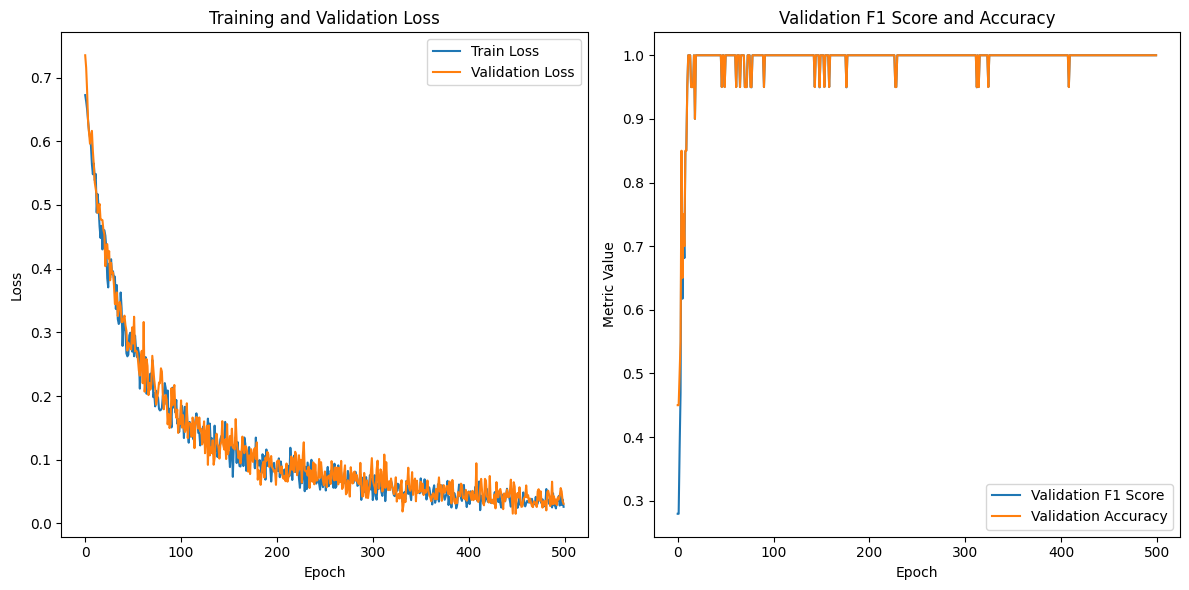

In [ ]:
# --- Plotting Learning Curves ---
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Metrics
plt.subplot(1, 2, 2)
plt.plot(val_f1_scores, label='Validation F1 Score')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Validation F1 Score and Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(plots_save_dir, "learning_curves_3_classes.png")) # Сохраняем график
plt.show()